# Homework 11 Computational Problems: the PageRank algorithm

In this homework assignment, we investigate the original ranking algorithm developed by Larry Page and Sergey Brin, the founders of Google, to rank web pages based on importance.

The basic setup of the algorithm is as follows: suppose a user searches for the term "linear algebra", and we find $N$ webpages containing a string match for this term. How do we determine which of these $N$ pages are most relevant? The key assumption that the PageRank algorithm utilizes is that more important webpages are more likely to have other pages linking to it. 

We represent the stucture of interlinking webpages as a _graph_, i.e. an object consisting of $N$ vertices (webpages) and edges. There is an edge connecting vertex $i$ to vertex $j$ page $i$ links to page $j$. The structure of such a graph can be represented by an $N\times N$ _adjacency matrix_ $\boldsymbol{L}$ such that 

$$
L_{ij} = \begin{cases}1 & \text{if $j$ links to $i$}\\ 0 & \text{otherwise} \end{cases}
$$

(by default we always assume $L_{ii} = 0$). Consider the following simple example with four webpages.

In [4]:
# you need networkx installed to visualize the graphs
!pip install networkx

import numpy as np
import networkx as nx

The graph with adjacency matrix

[[0 0 1 0]
 [1 0 0 0]
 [1 1 0 1]
 [0 0 0 0]]

can be visualized as


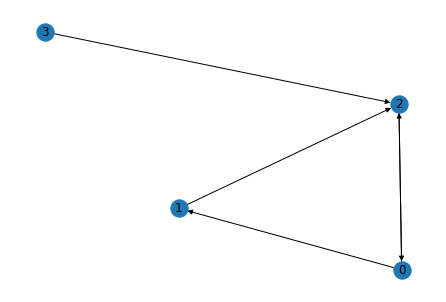

In [9]:
L = np.array([[0, 0, 1, 0], [1, 0, 0, 0], [1, 1, 0, 1], [0, 0, 0, 0]])
print('The graph with adjacency matrix')
print('')
print(L)
print('')
print('can be visualized as')

G = nx.from_numpy_matrix(L.T, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

Given a set of $N$ pages, the PageRank is a vector $\boldsymbol{p}\in \mathbb{R}^N$, such that $\boldsymbol{1}^\top \boldsymbol{p} = \sum_{i=1}^N p_i = N$, where here $\boldsymbol{1}$ is the all ones vector. The goal is to find $\boldsymbol{p}$ such that the most important pages have the largest entry in the PageRank vector. We can now describe the actual PageRank algorithm for finding $\boldsymbol{p}$.

The total number of output links from page $j$ is given by $d_j = \sum_{i=1}^N L_{ij}$. The PageRank algorithm defines the PageRanks as satisfying the following relation:

$$
p_i = (1-\alpha) + \alpha \sum_{j=1}^N \frac{L_{ij}}{d_j}p_j \;\;\;\;\;\; (1)
$$

Let's interpret what is happening in this equation. Inuitively, the component $\sum_{j=1}^N L_{ij}p_j/d_j$ relation says that the importance $p_i$ of page $i$ is given by the weighted sum of the importance of pages which link to it, where the weights are $1/d_j$. This ensures that each page can distribute a total weight of 1 to other pages. The scalar $\alpha$ (apparently set to 0.85 in the original implementation) is a weighting factor which governs how much influence the rank other pages have on the importance of page $i$. 

## Part 1: a simple iterative approach

The goal is to find a probability vector $\boldsymbol{p} = (p_1,\dots, p_N)$ which satisfies the relation (1). One simple approach is as follows: 

1. initialize the PageRank vector $\boldsymbol{p}^{(0)} = (p_1^{(0)},\dots,p_N^{(0)}) = (1, \dots, 1)$ to be the all ones vector
2. for each $t=1,\dots, T$, perform the following
    - for each $i=1,\dots, N$ update $p_{i}^{(t+1)} = (1-\alpha) + \alpha\sum_{j=1}^N \frac{L_{ij}}{d_j}p_j^{(t)}$
3. after $T$ updates, return the PageRank vector $\boldsymbol{p}$. 

Implement the following interative approach (for, say, $T=20$ steps, using $\alpha = 0.85$) to find the PageRank vector $\boldsymbol{p}$ for the simple adjacency matrix $\boldsymbol{L}$ defined at the beginning of the notebook. Which page do you find is the most important? 

## Part 2: exploiting matrix properties

Note that we can write the relation (1) in matrix form as

$$
\boldsymbol{p} = (1-\alpha)\boldsymbol{1} + \alpha \boldsymbol{L}\boldsymbol{D}^{-1}\boldsymbol{p}
$$

where we define $\boldsymbol{D} = \text{diag}(d_1,\dots, d_N)$. Moreover, since we use the normalization $\boldsymbol{1^\top p} = N$, we can equivalently write this relation as 

$$
\begin{align*}
\boldsymbol{p} &= (1-\alpha)\boldsymbol{11^\top p}/N + \alpha \boldsymbol{L}\boldsymbol{D}^{-1}\boldsymbol{p}\\
&= [(1-\alpha)\boldsymbol{11}^\top/N + \alpha \boldsymbol{L}\boldsymbol{D}^{-1}] \boldsymbol{p}\\
&= \boldsymbol{Ap}
\end{align*}
$$

where we defined the $N\times N$ matrix $\boldsymbol{A} = (1-\alpha)\boldsymbol{11}^\top/N + \alpha \boldsymbol{L}\boldsymbol{D}^{-1}$. 

Now we arrive at something that should look familiar: $\boldsymbol{Ap} = \boldsymbol{p}$. This says that the PageRank vector $\boldsymbol{p}$ should be an _eigenvector_ of the matrix $\boldsymbol{A}$ associated with the eigenvalue 1.

It turns out we can actually prove that the matrix $\boldsymbol{A}$ defined above always has an eigenvalue of 1. However, let's verify that this is true. Again using the simple adjacency matrix $\boldsymbol{L}$ defined at the beginning of the notebook, construct the matrix $\boldsymbol{A}$ and find its eigenvalues. Verify that one of the eigenvalues is equal to 1, and find the eigenvector $\boldsymbol{p}$ associated with this eigenvalue, and rescale the vector so that it sums to $N$ (i.e. multiply by $N/\boldsymbol{1^\top p}$). Are the rankings of the pages in this eigenvector the same as what you found in Part 1?

## Part 3: the power method for large graphs

The two methods we investigated above seem to work well for the small example we tested them on, with only $N=4$ webpages. However, realistic web searches will of course involve *many* more pages than this (for example, if you Google "linear algebra" you will find 150,000,000+ results). In this case, neither of the methods described above will work; we don't want to update each of the individual PageRank entries manually, nor is it feasible to compute a full eigenvalue decomposition for $\boldsymbol{A}$ defined in Part 2. Instead, Google uses the power method to find the top eigenvector (which will always be associated with the eigenvalue 1) of the matrix $\boldsymbol{A}$. Here we will do the same.

To do this, we initialize $\boldsymbol{p}^{(0)} = (1,\dots, 1)$, and perform the following iterations for $t=1,\dots, T$:

$$
\tilde{\boldsymbol{p}}^{(t+1)} = \boldsymbol{A}\boldsymbol{p}^{(t)},\;\;\; \boldsymbol{p}^{(t+1)} = N\frac{\tilde{\boldsymbol{p}}}{\boldsymbol{1}^\top \tilde{\boldsymbol{p}}^{(t+1)}}
$$

Implement the power iterations for the following randomly generated adjacency matrix.

In [15]:
N = 1000

# randomly generate an N x N adjacency matrix
L = np.random.binomial(1, 0.3, size=(N,N))

# make sure all the diagonal entries are equal to zero
np.fill_diagonal(L, 0)

L

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 1],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])